In [ ]:
import pandas as pd
import numpy as np
import itertools

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, StratifiedKFold, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

from scipy.stats import loguniform, uniform

from imblearn.over_sampling import SMOTE, RandomOverSampler

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress all warnings for cleaner output
warnings.filterwarnings('ignore')

## 1. Dataset Loading

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
# Drop the 'id' column as it's just an identifier and not a predictive feature
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

## 2. Exploratory Data Analysis (EDA) and Missing Value Analysis

In [3]:
print("Original Dataset Head:")
df.head()

Original Dataset Head:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
print("\nDataset shape:", X.shape)


Dataset shape: (2011, 10)


In [5]:
print("Target variable distribution (0: no stroke, 1: stroke):\n", y.value_counts())

Target variable distribution (0: no stroke, 1: stroke):
 stroke
0    1762
1     249
Name: count, dtype: int64


In [6]:
print(f"Stroke percentage: {y.value_counts(normalize=True)[1]:.2%}")

Stroke percentage: 12.38%


In [7]:
print("\n--- 2. Exploratory Data Analysis (EDA) and Missing Value Analysis ---")
print("Dataset Info:")
X.info()


--- 2. Exploratory Data Analysis (EDA) and Missing Value Analysis ---
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             2011 non-null   object 
 1   age                2011 non-null   float64
 2   hypertension       2011 non-null   int64  
 3   heart_disease      2011 non-null   int64  
 4   ever_married       2011 non-null   object 
 5   work_type          2011 non-null   object 
 6   Residence_type     2011 non-null   object 
 7   avg_glucose_level  2011 non-null   float64
 8   bmi                1906 non-null   float64
 9   smoking_status     2011 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 157.2+ KB


In [8]:
print("\nDescriptive Statistics for Numerical Features:")
X.describe()


Descriptive Statistics for Numerical Features:


,age,hypertension,heart_disease,avg_glucose_level,bmi
count,2011.000000,2011.000000,2011.000000,2011.000000,1906.000000
mean,45.257524,0.110890,0.065639,108.851581,29.220094
std,22.803875,0.314074,0.247712,47.479935,7.845703
min,0.080000,0.000000,0.000000,55.220000,10.300000
25%,27.000000,0.000000,0.000000,77.845000,23.900000
50%,48.000000,0.000000,0.000000,93.280000,28.300000
75%,63.000000,0.000000,0.000000,118.085000,33.500000
max,82.000000,1.000000,1.000000,271.740000,78.000000


In [9]:
print("\nPercentage of missing values per column:")
missing_percentages = X.isnull().sum(axis=0) / X.shape[0]
print(missing_percentages[missing_percentages > 0]) # Only show columns with missing values


Percentage of missing values per column:
bmi    0.052213
dtype: float64


## --- 3. Definition of the Data Transformation Pipeline ---

In [10]:
# Separate features into numerical and categorical based on common sense for this dataset
numerical_features = ['age', 'avg_glucose_level', 'bmi']
# 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status' are categorical
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status',] # Treat these as categorical for one-hot encoding

# Pipeline for numerical features: Imputation (for 'bmi') and Scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # 'bmi' often has missing values, 'mean' is a common strategy
    ('scaler', StandardScaler())
])

# Pipeline for categorical features: Imputation (if any) and One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # For any potential missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # 'ignore' new categories in test set
])

In [11]:
# Create a ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop', # Drop columns not specified
    verbose_feature_names_out=False, # To get clean feature names out of OneHotEncoder
    sparse_threshold=0 # Ensure dense output for subsequent steps (e.g., classifiers)
)

print("Data transformation pipelines defined.")

Data transformation pipelines defined.


# --- 4. Training and Test Sets ---

In [12]:
# Use stratify=y because the 'stroke' target is highly imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")

Training set shape: (1608, 10), Test set shape: (403, 10)
Training target distribution:
stroke
0    0.876244
1    0.123756
Name: proportion, dtype: float64
Test target distribution:
stroke
0    0.875931
1    0.124069
Name: proportion, dtype: float64


In [13]:
# Initial pipeline structure for nested cross-validation
# We'll use a placeholder classifier that will be tuned by RandomizedSearchCV.
# model_pipeline = ImbPipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', LogisticRegression()) # This will be replaced by specific classifiers during tuning
# ])
model_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', Perceptron())
])

In [14]:
# Sanity check (optional, but good practice)
print("\nSanity check for initial pipeline:")
try:
    model_pipeline.fit(X_train, y_train)
    _ = model_pipeline.predict(X_test)
    print("Initial pipeline fit and predict successful.")
except Exception as e:
    print(f"Error during initial pipeline sanity check: {e}")


Sanity check for initial pipeline:
Initial pipeline fit and predict successful.


In [15]:
# Define hyperparameter configurations for different classifiers
# Added `random_state` for reproducibility for stochastic models.
# Added `class_weight='balanced'` for Logistic Regression and Decision Tree
# or `scale_pos_weight` for Gradient Boosting if imbalance is significant,
# or could use SMOTE (from imblearn) as a separate pipeline step before classifier.
# Given the high imbalance in typical stroke datasets, 'balanced' class weights are good.

sampler_configs = [
    {
        'sampler':[None],# The element is bypassed
    },
    {
        'sampler':[SMOTE()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    }
]


classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001,100),
        'classifier': [Perceptron()] ,
        'classifier__max_iter': [1,5,10,15,50,100] ,
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C' : loguniform(0.001,100),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,5,7,9]
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10,50,100, 500]
    },
    {
        'classifier': [XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)], # Important: use_label_encoder=False to suppress warning
        'classifier__n_estimators': [50, 100, 200, 300],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7, 9],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],
        'classifier__gamma': [0, 0.1, 0.2],
        # Handling imbalance:
        # Calculate this value based on your training data's class distribution.
        # Example: if y_train has 950 '0's and 50 '1's, scale_pos_weight = 950/50 = 19.
        # You'd typically pass a list of potential values around the calculated ratio.
        # Or, pass [1] to allow the model to try without explicit scaling.
        'classifier__scale_pos_weight': [1, (y_train.value_counts()[0] / y_train.value_counts()[1]), (y_train.value_counts()[0] / y_train.value_counts()[1]) * 0.5, (y_train.value_counts()[0] / y_train.value_counts()[1]) * 2]
    }
]

In [16]:
# Generate all possible configurations by simply appending classifier_configs.
# If you had other pipeline steps (e.g., dimensionality reduction, oversampling)
# you would use itertools.product as in your template to combine their configs.
all_configs = []
for sampler_config, dim_reduction_config, classifier_config in itertools.product(sampler_configs, dim_reduction_configs, classifier_configs):
    # Merge the dictionaries into a single dictionary
    combined_config = {}
    combined_config.update(sampler_config)
    combined_config.update(dim_reduction_config)
    combined_config.update(classifier_config)
    all_configs.append(combined_config)

print(f"\nNumber of different base classifier configurations for RandomizedSearchCV: {len(all_configs)}")


Number of different base classifier configurations for RandomizedSearchCV: 45


In [17]:
# Define RandomizedSearchCV for the inner loop
# Using `RepeatedStratifiedKFold` for `cv` for more robust results in the inner loop as well.
rs = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 4, # Number of parameter settings that are sampled. Adjust based on computational budget.
    n_jobs=-1, # Use all available CPU cores
    cv=2,
    scoring='f1', # F1-score is crucial for imbalanced datasets
    random_state=42, # For reproducibility of random sampling
)

In [18]:
scores = cross_validate(rs, X_train, y_train,
                        scoring='f1', # Consistent F1-score for evaluation
                        cv=5,
                        return_estimator=True, # Important to get the best estimator from each inner fold
                        verbose=3,
                        n_jobs=-1) # Use parallel processing for outer folds if possible

print("\nNested cross-validation complete.")
print("Cross-validation F1-scores for each fold:", scores['test_score'])
print(f"Mean F1-score across outer folds: {np.mean(scores['test_score']):.4f}")
print(f"Standard deviation of F1-score across outer folds: {np.std(scores['test_score']):.4f}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Nested cross-validation complete.
Cross-validation F1-scores for each fold: [0.42580645 0.4109589  0.41726619 0.         0.47058824]
Mean F1-score across outer folds: 0.3449
Standard deviation of F1-score across outer folds: 0.1737


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.7s remaining:   38.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.7s finished


# --- 6. Evaluation of Best Candidates ---

In [19]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

RandomOverSampler(sampling_strategy=0.9)
LinearDiscriminantAnalysis()
LogisticRegression(C=np.float64(0.041189105896489775), solver='saga') {'C': np.float64(0.041189105896489775), 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.4258064516129032
----------
RandomOverSampler(sampling_strategy=0.9)
LinearDiscriminantAnalysis()
Perceptron(class_weight='balanced', eta0=np.float64(85.32056493640629),
           max_iter=100) {'alpha': 0.0001, 'class_weight': 'balanced', 'early_stopping': False, 'eta0': np.float64(85.32056493640629), 'fit_intercept': True, 'l1_ratio': 0.15, 'max_iter': 100, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': None, 'random_state': 0, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.4109589041095

# --- 7. Refinement of the Selected Model ---


In [20]:
# Select the overall best estimator based on mean test_score from the outer CV
best_overall_f1_idx = np.argmax(scores['test_score'])
best_overall_estimator_pipeline = scores['estimator'][best_overall_f1_idx].best_estimator_

In [21]:
# Get the type of the best classifier for targeted refinement
best_classifier_type = type(best_overall_estimator_pipeline.named_steps['classifier'])
print(f"Refining model based on the best performing classifier from nested CV: {best_classifier_type.__name__}")

Refining model based on the best performing classifier from nested CV: Perceptron


In [22]:
# Define a specific pipeline for refinement using the structure and best classifier found
refined_model_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomOverSampler()),
    ('classifier', LogisticRegression(solver='saga', penalty = 'l1'))
])

In [23]:
# Define a narrower parameter search space for refinement based on the best classifier's type
refinement_params = {
    'classifier__C': uniform(loc = 15, scale = 60),
    'sampler__sampling_strategy': ['minority', 0.85, 0.9, 0.95]
}

In [24]:
rs_best = RandomizedSearchCV(
    estimator=refined_model_pipeline,
    param_distributions=refinement_params,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42),
    n_iter=50,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rs_best.fit(X_train, y_train)

print(f"\nBest parameters after refinement: {rs_best.best_params_}")
print(f"Best F1 score after refinement (on CV folds): {rs_best.best_score_:.4f}")
final_best_model = rs_best.best_estimator_

Fitting 15 folds for each of 50 candidates, totalling 750 fits

Best parameters after refinement: {'classifier__C': np.float64(57.48435466776273), 'sampler__sampling_strategy': 0.85}
Best F1 score after refinement (on CV folds): 0.4440


# --- 8. Final Evaluation and Visualization ---


In [ ]:
y_test_pred_final = final_best_model.predict(X_test)
final_accuracy_score = accuracy_score(y_test, y_test_pred_final)
final_precision_score = precision_score(y_test, y_test_pred_final)
final_recall_score = recall_score(y_test, y_test_pred_final)
final_f1_score = f1_score(y_test, y_test_pred_final)
final_roc_auc_score = roc_auc_score(y_test, final_best_model.predict_proba(X_test)[:, 1])

print(f"Final Accuracy Score on the held-out test set: {final_accuracy_score:.4f}")
print(f"Final Precision Score on the held-out test set: {final_precision_score:.4f}")
print(f"Final Recall Score on the held-out test set: {final_recall_score:.4f}")
print(f"Final F1-score on the held-out test set: {final_f1_score:.4f}")
print(f"Final ROC AUC score on the held-out test set: {final_roc_auc_score:.4f}")

Final F1-score on the held-out test set: 0.4205
Final ROC AUC score on the held-out test set: 0.8367
Classification Report on Test Set (Final Model):
              precision    recall  f1-score   support

           0       0.95      0.75      0.84       353
           1       0.29      0.74      0.42        50

    accuracy                           0.75       403
   macro avg       0.62      0.74      0.63       403
weighted avg       0.87      0.75      0.79       403




Confusion Matrix for the Final Model:


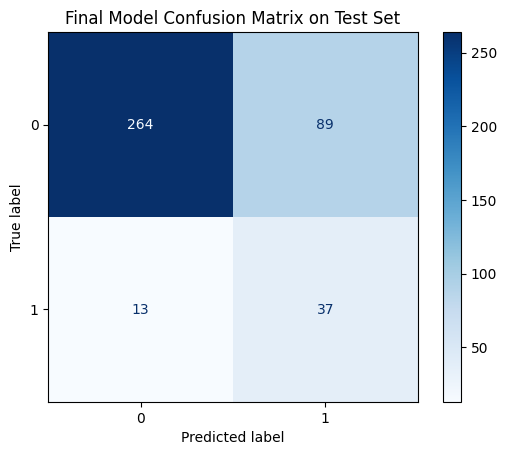

In [26]:
# Confusion Matrix for the final model
print("\nConfusion Matrix for the Final Model:")
cm_final = confusion_matrix(y_test, y_test_pred_final, labels=final_best_model.classes_)
disp_final = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=final_best_model.classes_)
disp_final.plot(cmap=plt.cm.Blues)
plt.title("Final Model Confusion Matrix on Test Set")
plt.show()



Generating Learning Curve...


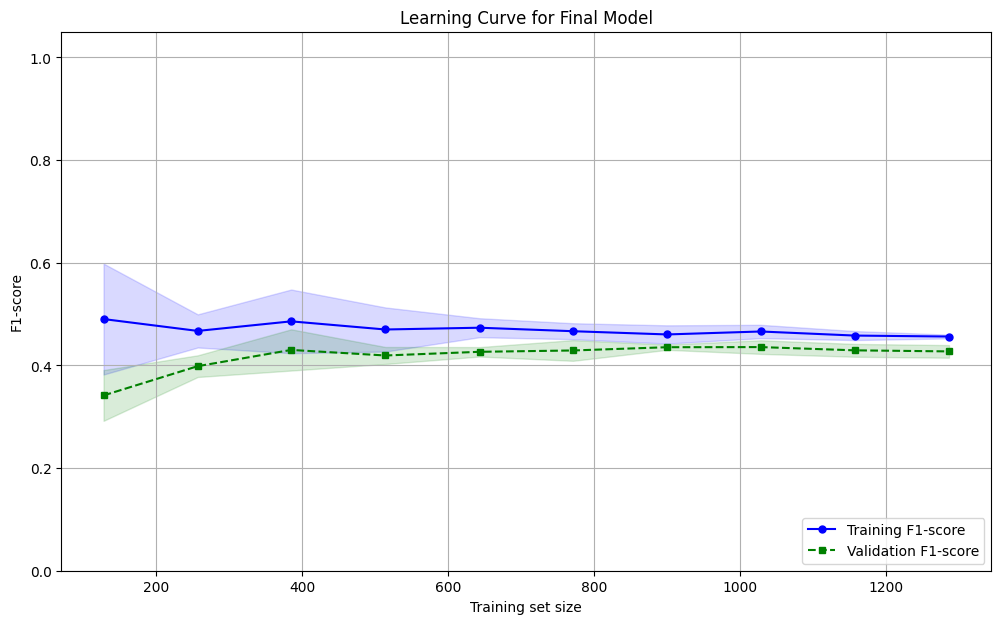

In [27]:
# Learning Curve
print("\nGenerating Learning Curve...")
# Ensure the model for learning curve is fitted before passing it.
# `final_best_model` is already the best fitted from refinement or nested CV.
train_sizes, train_scores, test_scores = learning_curve(
    final_best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10), # 10 different sizes
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    scoring='f1',
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 7))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training F1-score')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation F1-score')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Training set size')
plt.ylabel('F1-score')
plt.title('Learning Curve for Final Model')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.05]) # Adjusted y-limit for F1 scores common with imbalance
plt.show()